# Introduction

The **Flowers-102 dataset** is a popular dataset used for image classification tasks, particularly in the field of fine-grained visual categorization. It contains images of **102** different types of flowers. The dataset is structured with **8,189** images, where each class (flower type) has between **40 to 258** images. The classes are not evenly distributed, making it a realistic dataset for classification tasks.

In this notebook, two convolutional neural networks (CNNs) will be trained and evaluated on classifying the dataset. Each network will have a different architecture and their performance will be copmared.

# Loading the Dataset

The dataset can be retrieved from TorchVision datasets, and then can be split into training, validation, and testing datasets.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Make sure the runtime is on the GPU.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Here we define some transform properties to be done on the datasets. We resize all datasets to 224x224, and apply random rotations and flips to the training set so that the models will have a lower probability of overfitting. And we split the sets using a batch size of 32.

In [3]:
transforms_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transforms_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transforms_train)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transforms_test)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transforms_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 344862509/344862509 [00:13<00:00, 26202843.57it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 844242.43it/s]


100%|██████████| 14989/14989 [00:00<00:00, 19016461.78it/s]


# Visualizing the Dataset

We can visualize the images of the flowers with their classes, along with the random transformations.

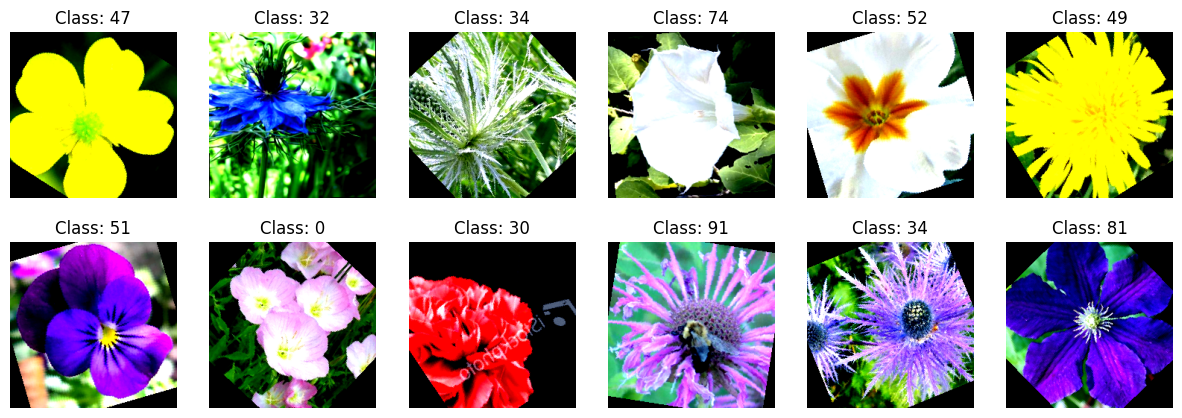

In [6]:
def show_images(dataset, num_images=6):
    loader = DataLoader(dataset, batch_size=num_images*2, shuffle=True)
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images.numpy().transpose((0, 2, 3, 1))
    images = images * 0.5 + 0.5
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax = axes[0][i]
        ax.imshow(images[i])
        ax.set_title(f'Class: {labels[i].item()}')
        ax.axis('off')

    for i in range(num_images):
        ax = axes[1][i]
        ax.imshow(images[i+6])
        ax.set_title(f'Class: {labels[i+6].item()}')
        ax.axis('off')
    plt.show()

show_images(train_dataset)

In [5]:
print('Train Loader Size:\t', train_loader.dataset[0][0].shape)
print('Validation Loader Size:\t', val_loader.dataset[0][0].shape)
print('Test Loader Size:\t', test_loader.dataset[0][0].shape)

Train Loader Size:	 torch.Size([3, 224, 224])
Validation Loader Size:	 torch.Size([3, 224, 224])
Test Loader Size:	 torch.Size([3, 224, 224])


In [78]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

sample_image, sample_label = train_dataset[0]
print(f"Shape of an image: {sample_image.shape}")

print(f"Image channels: {sample_image.shape[0]}")
print(f"Image height: {sample_image.shape[1]}")
print(f"Image width: {sample_image.shape[2]}")

Number of training samples: 816
Number of validation samples: 204
Number of test samples: 6149
Shape of an image: torch.Size([3, 224, 224])
Image channels: 3
Image height: 224
Image width: 224


All datasets contain images of the shape (3, 224, 224):
  - Image channels: 3
  - Image height: 224
  - Image width: 224

The ratio of training to validation samples is 8:2, and the test dataset has 6149 samples.

# Verifying Dataset

To verify data before training the models:

In [79]:
def check_data_loader(loader):
    for images, labels in loader:
        print(f"Image shape: {images.shape}")
        print(f"Labels: {labels}")
        break

check_data_loader(train_loader)

Image shape: torch.Size([32, 3, 224, 224])
Labels: tensor([ 59, 100,  75,  51,  58,  27,  37,  92,   1,  53,  56,  78,  86,  76,
         79,  67,  64,  53,  35,  29,  79,  85,   3,  39,  55,  16,  89,  46,
         83,  87,  48,  67])


- The image batch has the shape (32, 3, 224, 224), confirming that each batch contains 32 images of size 224x224 with 3 channels.
- The labels are integers representing the class indices for each image in the batch.

# Building CNNs

## Simple CNN

To build the simple CNN, it will have 5 hidden layers, two convolutional and three fully connected. The CNN will start with 3 inputs since it takes in RGB images, and end with 102 outputs, since the dataset has 102 classes.

The kernel size used will be 3x3 (odd number), since it's a standard for small receptive fields.

Padding will always be 1 as to maintain the spatial dimensions after convolution.

In [80]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 56 * 56, 256) # 128 *56 *56 = 401408
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 102) # 102 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Max pooling was used to reduce the spatial dimensions, which reduces the width and height of the feature maps by half (224 -> 112 -> 56).

## Deeper CNN

The deeper CNN will be more complex and have deeper hidden layers. It has 7 convolutional layers with increasing complexity, and 4 fully connected layers, making it have 11 layers in total.

Between these layers there are batch normalization layers, which normalize the activations of previous layers, and in turn improving training and stability.

In [81]:
class DeeperCNN(nn.Module):
    def __init__(self):
      super(DeeperCNN, self).__init__()
      self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
      self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
      self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
      self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
      self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
      self.conv7 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

      self.bn1 = nn.BatchNorm2d(64)
      self.bn2 = nn.BatchNorm2d(128)
      self.bn3 = nn.BatchNorm2d(256)
      self.bn4 = nn.BatchNorm2d(512)
      self.bn5 = nn.BatchNorm2d(512)
      self.bn6 = nn.BatchNorm2d(1024)
      self.bn7 = nn.BatchNorm2d(1024)

      self.pool = nn.MaxPool2d(2, 2)

      self.fc1 = nn.Linear(1024, 2048)
      self.fc2 = nn.Linear(2048, 1024)
      self.fc3 = nn.Linear(1024, 512)
      self.fc4 = nn.Linear(512, 102)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        x = self.pool(F.relu(self.bn7(self.conv7(x))))

        x = torch.flatten(x, 1)  # Flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Training and Evaluation

## Defining Method

The training and evalutaion will be done on the GPU, so we make sure that it's available here as well. It will be done on 30 epochs.

The loss function used is the **CrossEntropyLoss**, commonly used for classification problems. The optimizer is **Adam** with a learning rate of **0.0001.**

This value of the learning rate was decided after trying the values (0.1, 0.001, 0.0005, 0.00001) and finding the best accuracy with **0.0001**.

This method will use a helper function to initialize weights using the kaiming uniform intialization method, which initializes biases to 0 for ReLU functions.

In [83]:
def train_and_evaluate(model, num_epochs=30):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(f'{device}\n\n')
  model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)

  def initialize_weights(m):
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
          if m.bias is not None:
              nn.init.constant_(m.bias, 0)

  model.apply(initialize_weights)
  print(f"Training and Validating (lr={optimizer.param_groups[0]['lr']}):")

  train_losses = []
  val_losses = []
  val_accuracies = []
  epochs = []

  for epoch in range(num_epochs):
      # Training phase
      model.train()
      running_train_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_train_loss += loss.item()

      # Validation phase
      model.eval()
      running_val_loss = 0.0
      all_val_preds = []
      all_val_labels = []
      with torch.no_grad():
          for data in val_loader:
              inputs, labels = data
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = model(inputs)
              loss = criterion(outputs, labels)
              running_val_loss += loss.item()

              _, predicted = torch.max(outputs.data, 1)
              all_val_preds.extend(predicted.cpu().numpy())
              all_val_labels.extend(labels.cpu().numpy())

      # Calculate validation metrics
      val_accuracy = accuracy_score(all_val_labels, all_val_preds)
      val_loss = running_val_loss / len(val_loader)
      train_loss = running_train_loss / len(train_loader)

      train_losses.append(train_loss)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      epochs.append(epoch + 1)

      print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')

  # Final Evaluation on Test Set
  print("Evaluating:")
  model.eval()
  all_test_preds = []
  all_test_labels = []
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          all_test_preds.extend(predicted.cpu().numpy())
          all_test_labels.extend(labels.cpu().numpy())

  test_accuracy = accuracy_score(all_test_labels, all_test_preds)
  test_precision = precision_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)
  test_recall = recall_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)
  test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)

  print(f'Test Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}\n-------')

  plt.figure(figsize=(12, 10))

  plt.subplot(3, 1, 1)
  plt.plot(epochs, train_losses, label='Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training Loss over Epochs')
  plt.legend()

  plt.subplot(3, 1, 2)
  plt.plot(epochs, val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Validation Loss over Epochs')
  plt.legend()

  plt.subplot(3, 1, 3)
  plt.plot(epochs, val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Validation Accuracy over Epochs')
  plt.legend()

  plt.tight_layout()
  plt.show()


## Training and Evaluating SimpleCNN

cuda


Training and Validating (lr=0.0001):
Epoch 1, Train Loss: 26.843312919139862, Val Loss: 6.541750952601433, Val Accuracy: 0.03137254901960784
Epoch 2, Train Loss: 4.966584727168083, Val Loss: 4.569140940904617, Val Accuracy: 0.010784313725490196
Epoch 3, Train Loss: 4.518963515758514, Val Loss: 4.579158753156662, Val Accuracy: 0.026470588235294117
Epoch 4, Train Loss: 4.491061821579933, Val Loss: 4.538797773420811, Val Accuracy: 0.026470588235294117
Epoch 5, Train Loss: 4.425711557269096, Val Loss: 4.516587346792221, Val Accuracy: 0.03137254901960784
Epoch 6, Train Loss: 4.391467317938805, Val Loss: 4.402358204126358, Val Accuracy: 0.05588235294117647
Epoch 7, Train Loss: 4.323926076292992, Val Loss: 4.504209458827972, Val Accuracy: 0.04019607843137255
Epoch 8, Train Loss: 4.291130915284157, Val Loss: 4.476451136171818, Val Accuracy: 0.043137254901960784
Epoch 9, Train Loss: 4.268682695925236, Val Loss: 4.372706308960915, Val Accuracy: 0.05784313725490196
Epoch 10, Train Loss: 4.

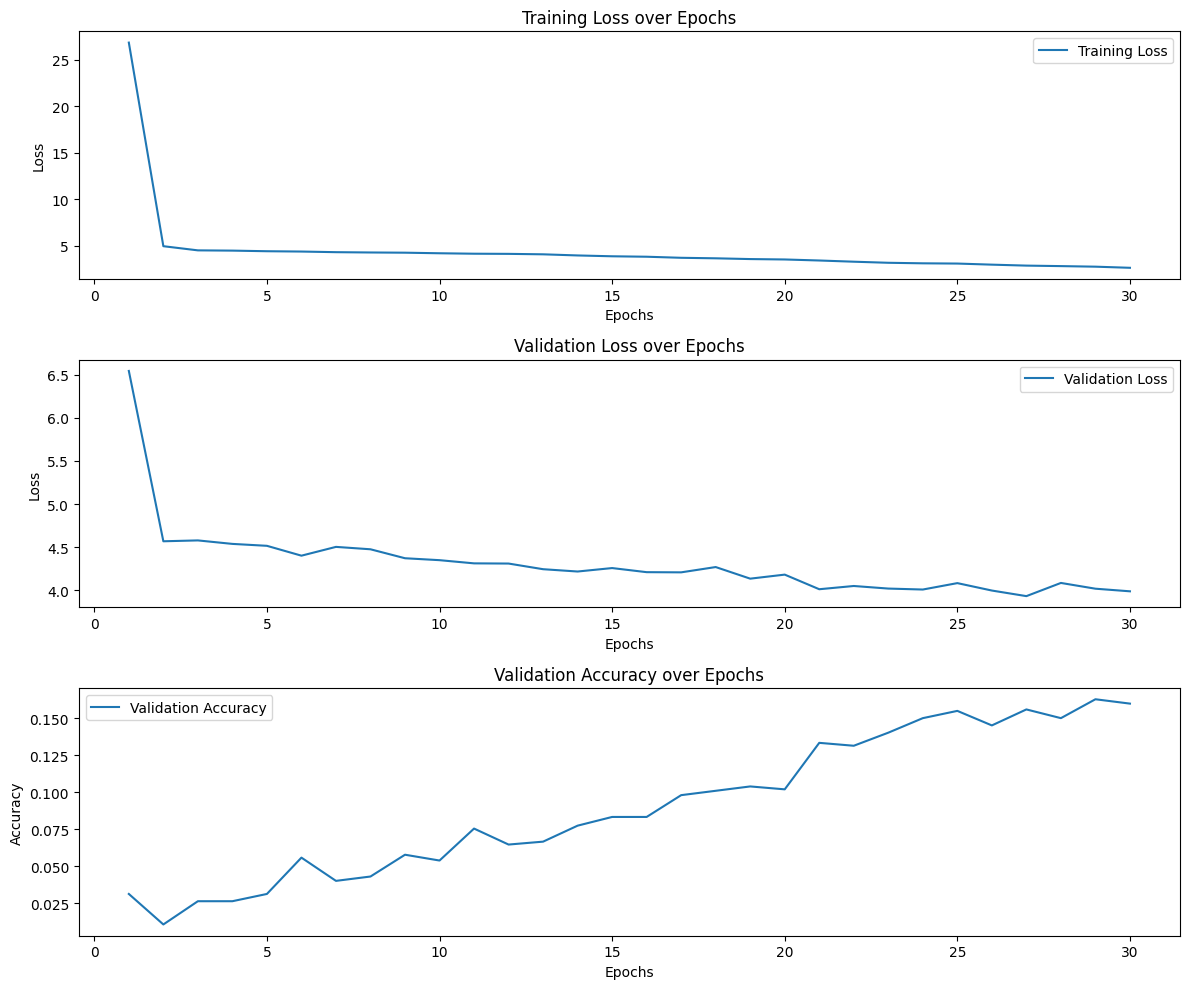

In [ ]:
# Train and evaluate SimpleCNN
simple_cnn = SimpleCNN()
train_and_evaluate(simple_cnn)

- The training loss decreases significantly after the first epoch, and keeps on decreasing gradually and slowly while epochs are increasing. Around Epoch 30, it becomes quite low (~2.65) indicating the model has learned the training data well.

- The validation loss starts as high as ~6.54 but drops after the first epoch to ~4.57. Then remains relatively stable around that value with slight fluctuations. This suggests that while the model is improving, the gains in reducing validation loss are not much after the initial learning phase.

- The validation accuracy improves consistently with more epochs, but it stays relatively low (~16%) even at Epoch 30. This indicates that it is not generalizing well enough to make better predictions on the validation set.

- The evaluation metrics on the test set,
  - Test Accuracy: 13.40%
  - Precision: 14.09%
  - Recall: 13.40%
  - F1 Score: 10.67%,

  indicate that the model has a low performance on the test set. The F1 score, which is a balance between precision and recall, is particularly low, indicating that the model struggles with both correctly identifying and correctly predicting the correct labels.

These results are due to the simplicity of the network. Possible improvements could include adding more layers and/or filters to improve the model, or using more image transformation techniques to improve generalization, or maybe even increasing the number of epochs to give the model more time to train.

## Training and Evaluating DeeperCNN

cuda


Training and Validating (lr=0.0001):
Epoch 1, Train Loss: 4.473429389297962, Val Loss: 3.7839742302894592, Val Accuracy: 0.1450980392156863
Epoch 2, Train Loss: 3.3610150143504143, Val Loss: 3.4209941774606705, Val Accuracy: 0.19411764705882353
Epoch 3, Train Loss: 2.8730022460222244, Val Loss: 3.1481529623270035, Val Accuracy: 0.2549019607843137
Epoch 4, Train Loss: 2.492167066782713, Val Loss: 3.0747319608926773, Val Accuracy: 0.26372549019607844
Epoch 5, Train Loss: 2.1887950114905834, Val Loss: 2.932882070541382, Val Accuracy: 0.29215686274509806
Epoch 6, Train Loss: 1.8881112895905972, Val Loss: 2.794555202126503, Val Accuracy: 0.3284313725490196
Epoch 7, Train Loss: 1.6218790858983994, Val Loss: 2.7924699895083904, Val Accuracy: 0.34019607843137256
Epoch 8, Train Loss: 1.3521636463701725, Val Loss: 2.580338830128312, Val Accuracy: 0.39019607843137255
Epoch 9, Train Loss: 1.14934042096138, Val Loss: 2.7166395504027605, Val Accuracy: 0.35980392156862745
Epoch 10, Train Loss:

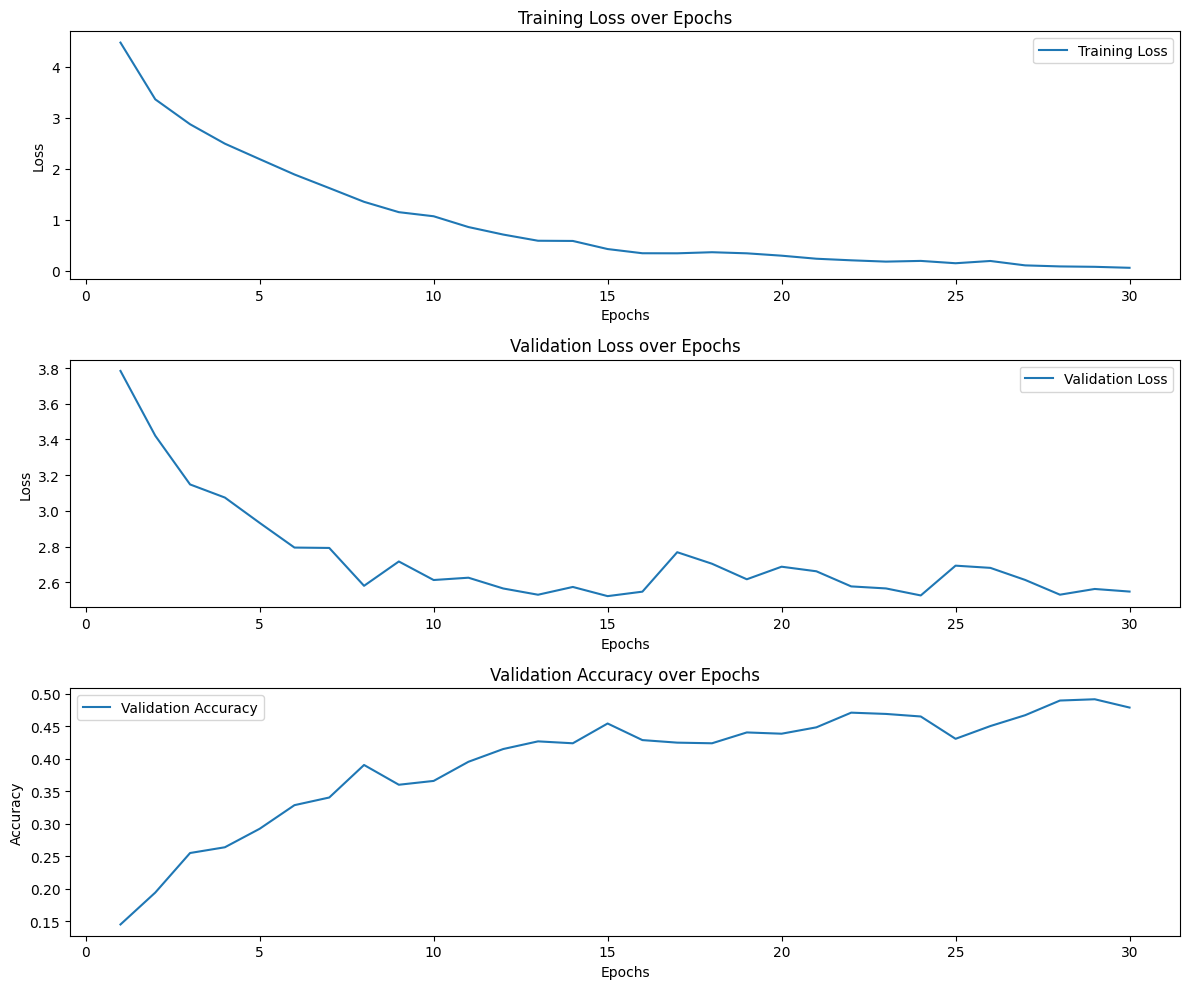

In [ ]:
# Train and evaluate DeeperCNN
deeper_cnn = DeeperCNN()
train_and_evaluate(deeper_cnn)

- The training loss decreases significantly after the first epoch, and keeps on decreasing gradually while epochs are increasing. Around Epoch 30, it becomes very low (~0.06) indicating the model has effectively learned the training data.

- The validation loss starts as high as ~3.78 and decreases to ~2.53 by the 30th epoch, with some fluctuations along the way. This shows that while the model is improving in validatoin loss, it still experiences minor instability, suggesting that the model is learning but still faces challenges in generalizing to unseen data.

- The validation accuracy improves consistently with more epochs,  reaching around 48.92% by Epoch 30. This shows a significant improvement over the SimpleCNN model but still indicates room for further enhancements in generalization and accuracy.

- The evaluation metrics on the test set,
  - Test Accuracy: 44.67%
  - Precision: 50.96%
  - Recall: 44.67%
  - F1 Score: 44.36%,

  indicate that the DeeperCNN model performs significantly better on the test set compared to the SimpleCNN. The F1 score is higher, indicating a better balance between precision and recall, but the performance still suggests the need for further model adjustments to reach higher levels of accuracy.

Althought the DeeperCNN shows signifcantly better results, its perfmormance can be improved further by finetuning the arechitecture through adding more layers, adjusting the filters, or trying different combinations of layers. It Could also benefit from experimenting with image transformations more (even though this was done but it resulted in lower accuracies). Or maybe increasing the number of epochs to let the model train for more time, but seeing as the plots for validation loss and accuracy are slowly showing stabilization aroun Epoch 30, this will not work without adjusting the network itself (also was tried before).

# Conclusion

- **SimpleCNN** initially demonstrates a large training loss, which steadily decreases to **2.65** by Epoch 30, demonstrating learning but with room for improvement. **DeeperCNN**, on the other hand, exhibits a more noticeable reduction in training loss, with values as low as **0.06** by the end of the 30th epoch, showing that its more complicated architecture successfully catches training data patterns, leading to a better fit.

- The **SimpleCNN** model shows a consistent validation loss after the first epoch but has low validation accuracy (about **16%** by Epoch 30), indicating weak generalization and predictive potential. **DeeperCNN**, on the other hand, begins with a smaller validation loss and gradually improves its validation accuracy, reaching over **49%** by Epoch 30, exhibiting significantly greater generalization and performance.

- The test set performance demonstrates the influence of architectural changes between models. **SimpleCNN** produces poor results, with accuracy, precision, recall, and F1 scores all less than **15%**, demonstrating difficulty in correctly identifying and predicting labels. In contrast, **DeeperCNN** produces substantially superior results, with accuracy and all other metrics over **44%**, highlighting the benefits of a deeper, more complicated architecture for capturing and generalizing patterns in the Flowers-102 dataset.

- The performance differences between **SimpleCNN** and **DeeperCNN** highlight the impact of model complexity. **SimpleCNN**'s simpler architecture, with fewer layers and filters, struggles to effectively learn and generalize from complex data, resulting in poor performance and overfitting. In contrast, **DeeperCNN**'s deeper and more complex architecture enables it to capture more intricate features and perform better. However, despite its superior performance, **DeeperCNN** still shows some instability in validation loss, indicating a need for further tuning or adjustments to improve its performance.

In conclusion, the **DeeperCNN** model, with its more complex architecture, clearly outperforms the simpler **SimpleCNN** in terms of training, validation, and test performance. The additional depth and parameters in **DeeperCNN** enable it to learn and generalize better from the Flowers-102 dataset, though further optimization could still yield additional gains. The results demonstrate the critical impact of architectural choices on the effectiveness of a model, especially when dealing with complex datasets like Flowers-102.
